챕터 04 랭그래프를 활용한 메모리 기능

- 4장에서는 AI 챗봇에 메모리 기능을 추가해 이전 대화 내용을 기억하고 참조할 수 있게 하는 방법을 다룸, LLM의 무상태 특성을 극복하기 위해 랭그래프(LangGraph)를 활용한 상태 저장 시스템 구축 방법을 설명하며, 그래프 기반 아키텍쳐로 대화 흐름을 관리하고 상태를 추적하는 방법 소개, 또한 채팅 기록의 효율적인 관리를 위한 테크닉을 실용적인 코드 예시와 함께 안내

- 3장에서는 인공지능 챗봇 애플리케이션에 최신 컨텍스트를 제공하는 방법을 살펴봄, 최신 컨텍스트를 제공하면 챗봇은 사용자 입력을 바탕으로 정확한 응답을 생성, 그러나 이 정도만으로는 실제 운영에 적합한 애플리케이션을 구축하기에 부족, 애플리케이션이 사용자와 직접 채팅을 주고 받으면서, 과거 대화 내역 및 관련 컨텍스트를 기억하도록 구현하려면 어떠한 방법을 선택해야 할지 확인 필요
- LLM은 무상태(상태를 저장하지 않음)로 상호작용, 프롬프트를 작성할 때 이전의 프롬프트나 응단 내용을 전혀 저장하지 않는 다는 뜻, LLM에 이런 정보를 제공하려면 이전 대화와 컨텍스트를 추적할 견고한 메모리 시스템이 필요, 최종 프롬프트는 기록된 정보를 LLM으로 전달하며, 이를 통해 일종의 기억(메모리)이 부여됨, 기본적인 메모리 기능을 탑재한 RAG 프로젝트의 구성은 아래 그림과 같음
- 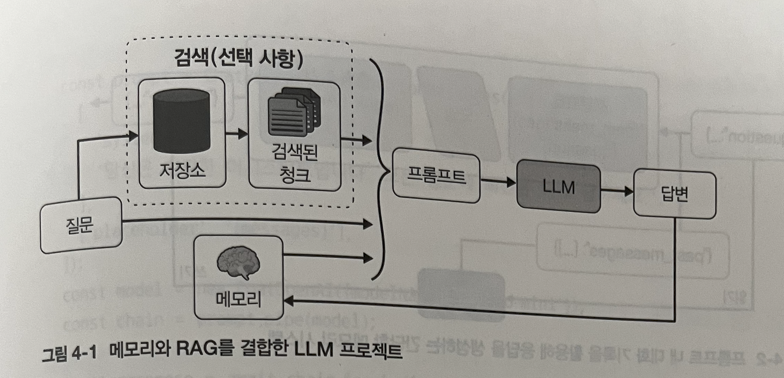

- 4.1. 챗봇 메모리 시스템 구축

- 견고한 메모리 시스템의 근간을 이루는 두 가지 핵심 설계적 결정은 아래와 같음
    - 상태 저장 방식
    - 상태 쿼리 방식

- 가장 간단한 챗봇 메모리 시스템 구축 방법은 사용자와 채팅 모델의 모든 대화 기록을 저장해 재활용하는 것, 이 메모리 시스템의 상태는 다음과 같이 처리
    - 메시지 목록 형태로 저장
    - 턴마다 최근 메시지를 추가해 업데이트
    - 메시지를 프롬프트에 추가

- 아래 그림은 단순한 메모리 시스템
- 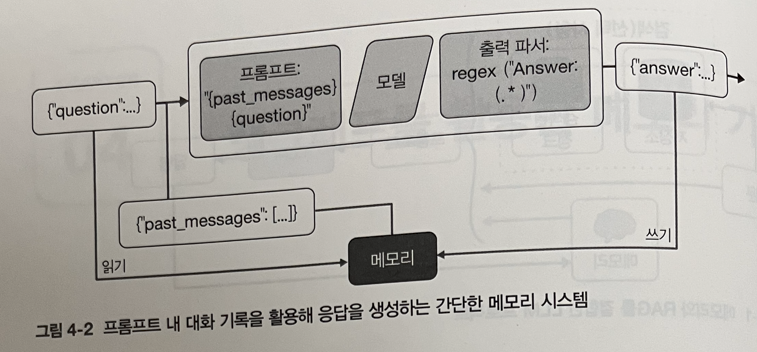

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    print("OPENAI_API_KEY가 .env 파일에 설정되지 않았습니다.")

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages([
    ("system", "당신은 친절한 어시스턴트입니다. 모든 질문에 최선을 다해 답하세요."),
    ("placeholder", "{messages}"),
])

model = ChatOpenAI(model="gpt-4o-mini")

chain = prompt | model

responce = chain.invoke({
    "messages": [
        ("human", "다음 한국어 문장을 프랑스어로 변역하세요.: 나는 프로그래밍을 좋아해요."),
        ("ai", "J\"adore programmer."),
        ("human", "뭐라고 말했죠?")
    ],
})

print(responce.content)

"J'adore programmer"라고 말했습니다. 이는 "나는 프로그래밍을 좋아해요"라는 의미입니다.


- 체인은 이전 대화 내용을 반영해 후속 질뮨에 컨텍스트를 고려한 적절한 응답을 출력, 간단한 메모리 시스템인 만큼 애플리케이션을 그대로 서비스하면 대규모 메모리 관리에서 문제가 생김
    - 모든 상호작용 후 메모리를 하나씩 업데이트 해야 한다(오류가 발생할 수 있으니 질문만 저장하거나 답변만 저장하는 일은 피함)
    - 이와 같은 메모리 자료를 관계형 데이터베이스 등 내구성이 뛰어난 저장소에 보관하는 편이 바람직
    - 이후 활용할 메시지의 종류와 개수를 선택해 저장하고, 이 중 새로운 상호작용에 사용할 메시지의 수를 조절해야 한다.
    - LLM 호출 외의 영역에서 상태(현재는 단순한 메시지 목록)를 점검하고 수정하는 편이 좋다.

- 4.2 랭그래프
    - 이번 장의 남은 부분과 이후 장에서는 랭체인이 제작한 오픈소스 라이브러리인 랭그래프를 활용, 랭그래프는 개발자가 그래프라는 다중 액터, 다단계, 상태 저장 인지 아키텍처 구조를 쉽게 구현할 수 있게 지원, 문장 하나에 여러 단어가 몰려 있으니 하나씩 체크 필요, 다중 액터는 아래 그림 참조
    - 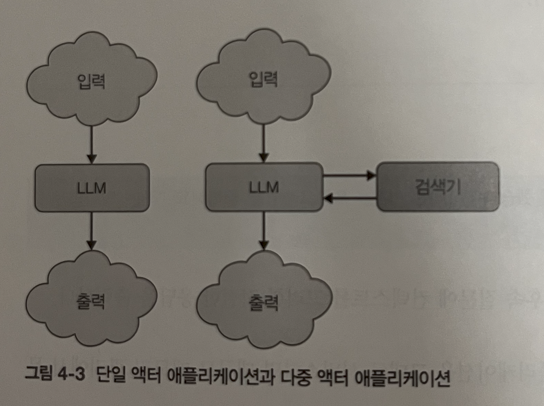

    - 전문가가 여럿 모이면, 혼자 실현하기 어려운 성과를 달성할 수 있음, LLM 애플리케이션도 마찬가지, 답변 생성, 작업 계획 수립 등 다방면에서 우수한 성능을 보이는 LLM 프롬프트는 최신 정보를 신속히 파악할 검색 엔진이나 다은 LLM 프롬프트와 결합하면 그 효력이 크게 증대, 이 두 가지 구성 요소(와 기타 요소)를 참신한 방식으로 결합해 퍼플랙시티나 아크 서치 처럼 뛰어난 애플리케이션을 구현한 사례가 다수 확인
    - 개인이 혼자 일하는 것보다 팀 단위의 작업에 더 정교한 협조 체계가 필요하듯, 다수의 주체가 관여하는 애플리케이션 역시 기능을 수행하는 데 체계적인 조정 계층이 필요함
        - 그래프에서 액터를 노드로 정의한 후, 액터 간에 업무가 전달되는 방식을 엣지로 나타냄
        - 각 액터의 실행을 적잘한 시점에 배치(필요시 병렬 처리)하고, 일정한 결과가 나오도록 함
    
    - 다단계는 아래 그림 참조
    - 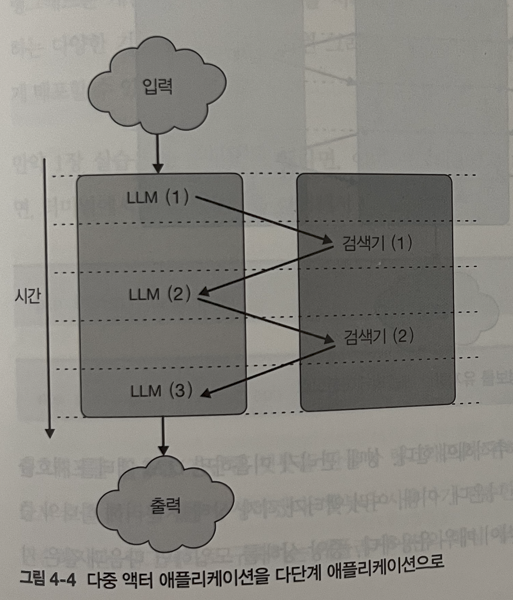

    - LLM 프롬프트가 검색 툴을 총해 특정 쿼리 결과를 요청하는 경우와 같이 각 액터가 작업을 다른 액터에 전달할 때 액터끼지 주고받는 작업을 명확히 파악해야 함, 이때 발생 순서와 각 액터의 호출 횟수 등 구체적인 정보가 필요, 이를 위해 액터 간 상호작용을 여러 개의 독립된 시간 단계로 구분해 모델링 함, 한 엑터가 다른 엑터에게 업무를 전달하면 다음 단계가 시작되고, 이러한 업무 인계가 연속적으로 이루어져 더 이상 인계할 대상이 없다면 최종 결과에 도달
    - 상태 저장은 아래 그림 참조
    - 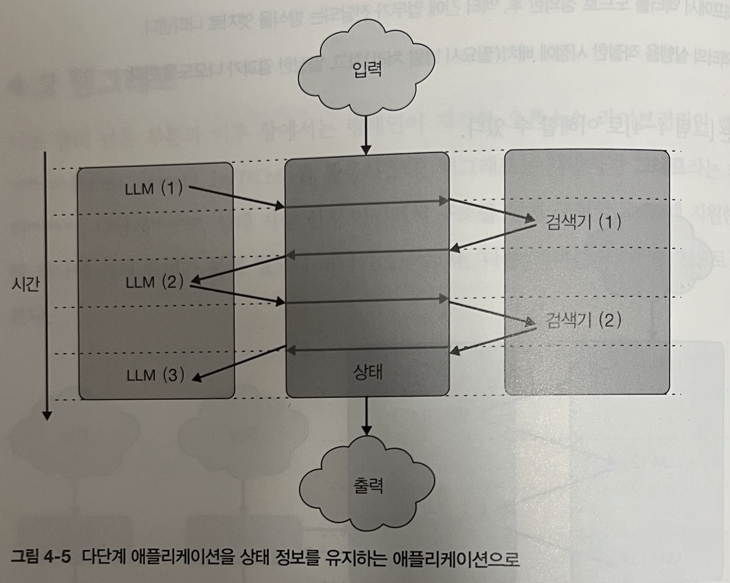

    - 단계 간 통신에선 반드시 상태를 추적해야 함, 상태 관리가 미흡하면 LLM 액터를 재호출해도 첫 번째 실행과 같은 결과가 나옴, 이때, 여러 액터가 각자 상태를 분리해 하나의 중앙 상태를 공유하며 갱신하는 방식이 매우 유용, 중앙 상태를 도입하면 다음과 같은 기능을 구현 가능
        - 각 계산 과정 중 또는 계산 완료 후에 중심 상태를 스냅샷에 저장
        - 오류 발생 시 손쉽게 복구할 수 있도록 실행을 일시 정지하고 재개
        - 사용자 개입 제어 체계를 구현
    - 그래프는 상태, 노드, 엣지로 구성
        - 상태: 외부에서 받은 데이터, 애플리케이션이 실행되는 동안 변경되고 생성
        - 노드: 진행할 단계, 노드를 주로 파이썬이나 JS 함수, 현재 상태를 입력받아 업데이트함(데이터를 추가하거나 수정하고 삭제할 수 있다.)
        - 엣지: 노드 사이 연결 관계, 엣지는 첫 번째 노드에서 마지막 노드까지 이어지는 경로를 나타냄, 엣지는 고정 엣지(예: 노드 B이후에 항상 노드 D를 방문)와 조건부 엣지(예: 함수를 사용해 노드 C 이후에 방문할 노드를 결정)가 있음.

    - 랭그래프는 개발 과정이나 그래프를 시각화 하는 도구와 각 그래프의 동작을 세밀하게 점검하는 다양한 기능을 제공, 이런 그래프를 활용하면 작업 부하가 큰 운영 환경에서 손쉽게 배포 가능

- 4.3. StateGraph 생성
    - 우선 StateGraph(상태 그래프)를 만들겠다. LLM을 호출하는 노드를 추가

In [5]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

- 그래프를 정의할 때 가장 먼저 해당 그래프의 상태를 정의해야 함, 상태는 그래프 상태의 구조(혹은 스키마)와 상태 업데이트 적용 방식을 규정하는 리듀서(reducer) 함수로 구성, 이번에는 상태를 단 한 개의 키만 가진 딕셔너리로 구성 진행, messages 에는 리듀서 함수 add_messages를 지정, 이 함수는 랭그래프가 기존 목록을 덮어쓰지 않고 신규 메시지를 추가하도록 지시, 주석이 없는 상태 키는 생신 시점마다 최종 값으로 대체, 자체 리듀서 함수를 구현할 수도 있음, 리듀서 함수는 첫 번째 인자로 현재 상태를 두 번째 인자로 상태에 기록될 값을 받아, 이들을 병합한 결과인 새로운 상태를 반환, 가장 간단한 예시는 리스트에 다음 값을 추가해 반환하는 함수

- 이제 그래프는 두 가지 일음 함
    - 정의된 모든 node는 현재의 State를 입력받아 해당 상태를 갱신하는 값을 반환
    - message는 직접 덮어쓰는 대신, 현재 목록에 새 메시지를 추가, 파이썬은 Annotated 구문에 지정한 add_messages 함수가 이 역할을 맡음

In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"message": [answer]}

# 챗봇 노드 추가
# 첫 번째 인자는 고유한 노드 이름
# 두 번째 인자는 실행할 함수 또는 Runnable
builder.add_node("chatbot", chatbot)

- 노드는 현재 상태를 받아 LLM을 한 번 호출해, LLM이 생성한 새 메시지를 포함한 상태 업데이트를 반환, 상태에 이미 저장된 메시지 목록에 새 메시지를 덧붙이는 add_messages 리뉴서가 있음, 마지막으로 엣지를 추가

In [7]:
# 엣지 추가
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

- 엣지는 몇가지 역할을 함